In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys
import os
import os.path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from user_function import MyAlgorithm
from alcon_utils import AlconUtils
import numpy as np
import cv2

def read_data(datasetdir, lv):
    alcon = AlconUtils(datasetdir)

    # アノテーションの読み込み
    fn = "target_lv" + lv + ".csv"
    alcon.load_annotations_target(fn)

    fn = "groundtruth_lv" + lv + ".csv"
    alcon.load_annotations_ground(fn)

    # KNNモデルの作成
    dataset = {}
    for bb_id, target in alcon.targets.items():
        img_filename = alcon.get_filename_char( bb_id )
        code = alcon.ground_truth[bb_id][0]
        if code not in dataset:
            dataset[code] = []
        #if len(dataset[code]) == 100:
        #    continue
        img = cv2.imread( img_filename )
        feature = MyAlgorithm.feature_extraction(img)
        dataset[code].append(feature)

    labels = []
    data = []
    classes = sorted(dataset.keys())
    for label, values in dataset.items():
        labels += [classes.index(label)] * len(values)
        data += values

    data = np.asarray(data, dtype=np.float)
    labels = np.asarray(labels, dtype=np.int)
    
    return data, labels, classes
    
def main(datasetdir,lv):
    data, labels, classes = read_data(datasetdir,lv)
    classifier = KNeighborsClassifier()
    classifier.fit(data, labels)

    outputfile = "./model.pkl"
    joblib.dump((classes, classifier), outputfile)

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

def main_keras_NN(datasetdir, lv):
    data, labels, classes = read_data(datasetdir,lv)


    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.2
    K.tensorflow_backend.set_session(tf.Session(config=config))
    
    batch_size = 128
    num_classes = 46
    epochs = 12
    img_rows, img_cols = 32, 32
    
    data = data.reshape(data.shape[0],img_rows,img_cols,3)
    input_shape = (img_rows, img_cols, 3)
    data = data.astype('float32')
    labels = keras.utils.to_categorical(labels, num_classes)
    
    classifier = Sequential()
    
    classifier.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape,padding='same'))
    classifier.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(Dropout(0.25))
    classifier.add(Flatten())
    classifier.add(Dense(128,activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(num_classes, activation='softmax'))
    
    classifier.compile(loss=keras.losses.categorical_crossentropy,
                       optimizer=keras.optimizers.Adadelta(),
                       metrics=['accuracy'])
    
    classifier.fit(data,labels,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=None)

    outputfile = "./model_iiyama.pkl"
    classifier.save(outputfile)

    outputfile2 = "./classes_iiyama.pkl"
    joblib.dump(classes, outputfile2)
      

Using TensorFlow backend.


In [ ]:
if __name__ == "__main__":
    if len(sys.argv) != 3:
        print("usage: python train.py datasetdir lv", file=sys.stderr)
        quit()

    main(sys.argv[1], sys.argv[2])

In [15]:
main_keras_NN("/share/alcon/dataset/","1")

Epoch 1/12
49353/49353 [==============================] - 6s - loss: 15.1743 - acc: 0.0581     
Epoch 2/12
49353/49353 [==============================] - 6s - loss: 15.1115 - acc: 0.0620     
Epoch 3/12
49353/49353 [==============================] - 6s - loss: 15.1220 - acc: 0.0614     
Epoch 4/12
49353/49353 [==============================] - 6s - loss: 15.0780 - acc: 0.0636     
Epoch 5/12
49353/49353 [==============================] - 6s - loss: 10.7673 - acc: 0.1059     
Epoch 6/12
49353/49353 [==============================] - 6s - loss: 2.1763 - acc: 0.4550     
Epoch 7/12
49353/49353 [==============================] - 6s - loss: 1.4555 - acc: 0.6239     
Epoch 8/12
49353/49353 [==============================] - 6s - loss: 1.1753 - acc: 0.6910     
Epoch 9/12
49353/49353 [==============================] - 6s - loss: 0.9835 - acc: 0.7402     
Epoch 10/12
49353/49353 [==============================] - 6s - loss: 0.8781 - acc: 0.7655     
Epoch 11/12
49353/49353 [===================

In [ ]:
model = keras.models.load_model('./model.pkl')

Populating the interactive namespace from numpy and matplotlib
['U+3057']


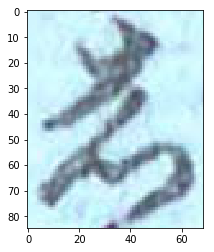

In [5]:
%pylab inline
import matplotlib.pyplot as plt
alcon = AlconUtils("/share/alcon/dataset/")
# アノテーションの読み込み
fn = "target_lv1.csv"
alcon.load_annotations_target(fn)
fn = "groundtruth_lv1.csv"
alcon.load_annotations_ground(fn)

idx = '1200'
rect = alcon.targets[idx][1:5]
image = cv2.imread("/share/alcon/dataset/images/"+alcon.targets[idx][0]+".jpg")
#cv2.rectangle(image, rect[0:2], (rect[0]+rect[2],rect[1]+rect[3]),(255,0,0), 2)
#plt.imshow(image[:,:,(2,1,0)])
plt.imshow(image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2],:])
#print ("/share/alcon/dataset/images"+alcon.targets[idx][0]+".jpg")
x = image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2],:].copy()
x = cv2.resize(x,(32,32))
x = x.reshape((1,32,32,3))
print (alcon.ground_truth[idx])

In [6]:
pred = model.predict_classes(x)
classes = joblib.load('./classes_iiyama.pkl')
classes[pred[0]]

NameError: name 'model' is not defined

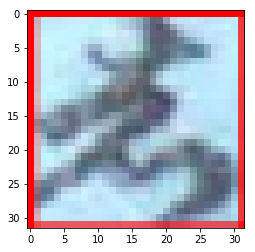

In [47]:
plt.imshow(x.reshape((32,32,3)))